In [ ]:
!pip uninstall -y flash-attn fsspec gcsfs transformers torch torchvision torchaudio
!pip install -q -U transformers accelerate bitsandbytes torch torchvision torchaudio datasets==2.14.6 fsspec==2023.9.2
!pip install -q -U rouge_score evaluate

Found existing installation: fsspec 2025.3.2
Uninstalling fsspec-2025.3.2:
  Successfully uninstalled fsspec-2025.3.2
Found existing installation: gcsfs 2025.3.2
Uninstalling gcsfs-2025.3.2:
  Successfully uninstalled gcsfs-2025.3.2
Found existing installation: transformers 4.53.2
Uninstalling transformers-4.53.2:
  Successfully uninstalled transformers-4.53.2
Found existing installation: torch 2.6.0+cu124
Uninstalling torch-2.6.0+cu124:
  Successfully uninstalled torch-2.6.0+cu124
Found existing installation: torchvision 0.21.0+cu124
Uninstalling torchvision-0.21.0+cu124:
  Successfully uninstalled torchvision-0.21.0+cu124
Found existing installation: torchaudio 2.6.0+cu124
Uninstalling torchaudio-2.6.0+cu124:
  Successfully uninstalled torchaudio-2.6.0+cu124
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.4/173.4 kB 12.9 MB/s

In [ ]:
import datasets
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import evaluate
from tqdm import tqdm
import torch
from itertools import islice
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [ ]:
billsum_train = datasets.load_dataset("billsum", split = "train", streaming = True)
billsum_test = datasets.load_dataset("billsum", split = "test")

billsum_test

Dataset({
    features: ['text', 'summary', 'title'],
    num_rows: 3269
})

In [ ]:
model_name = "google/bigbird-pegasus-large-arxiv"

tokenizer = AutoTokenizer.from_pretrained(model_name, from_pt=True)

tokenizer_config.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/1.92M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

In [ ]:
chunk_size = 1000
text_lengths = []
summary_lengths = []
for record in tqdm(islice(billsum_train, chunk_size), total = chunk_size):
  text_lengths.append(len(tokenizer(record["text"]).input_ids))
  summary_lengths.append(len(tokenizer(record["summary"]).input_ids))

100%|██████████| 1000/1000 [00:26<00:00, 37.04it/s]


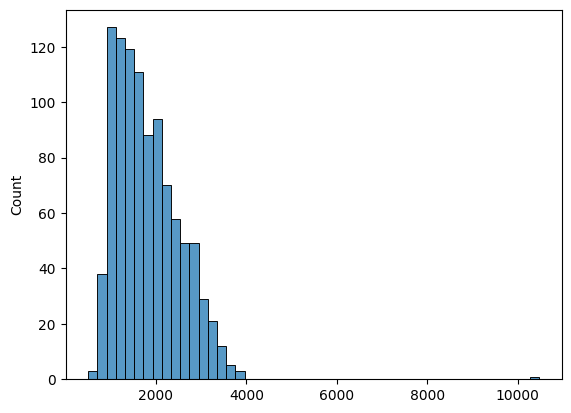

In [ ]:
sns.histplot(x = text_lengths)

plt.show()

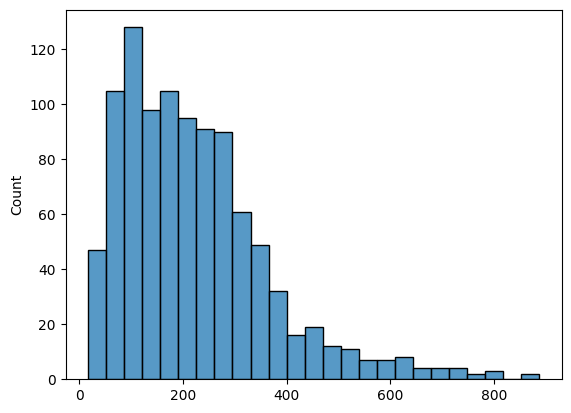

In [ ]:
sns.histplot(x = summary_lengths)

plt.show()

In [ ]:
# This cell will authenticate you and mount your Drive in the Colab.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
bigbird_predictions = {}
with open("drive/My Drive/266 - NLP/266 NLP Final Project/Data/billsum_test_bigbird_pred.jsonl", "r") as file:
  for line in file.readlines():
    record = json.loads(line)
    bigbird_predictions[record["title"]] = { "candidate": record["pred_summary"] }

len(bigbird_predictions.keys())

3269

In [ ]:
for record in billsum_test:
  try:
    bigbird_predictions[record["title"]]["reference"] = record["summary"]
  except:
    print("Couldn't find prediction for", record["title"])

In [ ]:
for i, (title, summaries) in enumerate(bigbird_predictions.items()):
  if i >= 5:
    break

  print(f"Example #{ i + 1 }")
  print("Title:", title)
  print("Reference:", summaries["reference"])
  print("Candidate:", summaries["candidate"])
  print()

Example #1
Title: To make technical corrections to the Water Resources Development Act of 1999.
Reference: Amends the Water Resources Development Act of 1999 to: (1) authorize appropriations for FY 1999 through 2009 for implementation of a long-term resource monitoring program with respect to the Upper Mississippi River Environmental Management Program (currently, such funding is designated for a program for the planning, construction, and evaluation of measures for fish and wildlife habitat rehabilitation and enhancement); (2) authorize the Secretary of the Army to carry out modifications to the navigation project for the Delaware River, Pennsylvania and Delaware, if such project as modified is technically sound, environmentally (currently, economically) acceptable, and economically justified; (3) subject certain previously deauthorized water resources development projects to the seven-year limitation governing project deauthorizations under the Act, with the exception of such a proje

In [ ]:
all_candidates = []
all_references = []

for summaries in bigbird_predictions.values():
  all_candidates.append(summaries["candidate"])
  all_references.append(summaries["reference"])

In [ ]:
rouge = evaluate.load('rouge')

rouge_scores = rouge.compute(predictions=all_candidates, references=all_references)
rouge_scores

{'rouge1': np.float64(0.193059882393256),
 'rouge2': np.float64(0.025338508049342366),
 'rougeL': np.float64(0.125943516267027),
 'rougeLsum': np.float64(0.14189313190322256)}

In [ ]:
bertscore = evaluate.load("bertscore")

bert_scores = bertscore.compute(predictions=all_candidates, references=all_references)
bert_scores